# Testing Notebook: Analysis of Touching Buildings
This file analyses a block of buildings in a dataframe containg 100 buildings.

### I) What can you learn from this notebook:
1. How to examine one building within a given building block
2. How to calculate the overlap between specific buildings
3. TBD

### II) Workflow
- at first ensure, that all input packages are installed in your environment
- adjust all paths to include feature engineering files and data

### III) TBD: 
- Add independent path structure
- Add highlight SharedwallLength in last Plot
- Add edgecases (building within other building, two touches)

## 1. Import packages and import buildings from .csv

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob
import argparse
import warnings

#---------- Set paths & import packages ----------#
# add paths to enable the import of the feature engineering modules
sys.path.append("/Users/Felix/Documents/Studium/PhD/05_Projects/02_Estimate_Building_Heights/00_Feature_Analysis")
from Utils.preproc_utils import import_csv_w_wkt_to_gdf,drop_z
from Utils.features_utils_cluster_francois import features_building_level

# add path for data import and export
path_to_data = '/Users/Felix/Documents/Studium/PhD/05_Projects/06_test_ufo_map'

#---------- Set Parameters ----------#
# Set building and feature params 
crs= 7794
drop_height = True
buffer_sizes=[50,200,500]

#---------- Import Data ----------#
# import file
path = os.path.join('/Users/Felix/Documents/Studium/PhD/05_Projects/06_test_ufo_map/Data/Data Test/Input/Udine_100_buildings.csv')
df = import_csv_w_wkt_to_gdf(path, crs)


## 2. Calculate TouchesIndex for df 

In [9]:
#---------- Calculate Features ----------#
# Drop height in geometry (if necessary)
if drop_height == True:
	df.geometry = df.geometry.apply(drop_z)

# Create empty result DataFrame
df_results = pd.DataFrame()

# Create a spatial index
df_spatial_index = df.sindex

# Create empty list
TouchesIndexes = []


for index, row in df.iterrows():

    # Case 1: the block has already been done
    already_in = [TouchesIndex for TouchesIndex in TouchesIndexes if index in TouchesIndex]

    if already_in != []:

        TouchesIndexes.append(already_in[0])

    else:

        # check if detached building
        possible_touches_index = list(df_spatial_index.intersection(row.geometry.bounds))
        possible_touches = df.iloc[possible_touches_index]
        precise_touches = possible_touches[possible_touches.intersects(row.geometry)]

        # Case 2: it is a detached building
        if len(precise_touches)==1:
            TouchesIndexes.append([index])

        # Case 3: the block is yet to be done
        else:

            current_index = index

            # lists output
            # buildings that have already been visited
            visited = []
            # directions that need to be explored (direction = index of a touching building)
            dir_to_explore = []

            # initiliaze stop
            it_is_over = False

            while it_is_over != True:

                # update index
                current_building = df.loc[current_index]

                # touch all buildings around current building
                possible_touches_index = list(df_spatial_index.intersection(current_building.geometry.bounds))
                possible_touches = df.iloc[possible_touches_index]
                precise_touches = possible_touches[possible_touches.intersects(current_building.geometry)]

                # add current building to the list of buildings already visited
                visited.append(current_building.name)

                # retrieve indices of buildings touching the current building
                touches_index = precise_touches.index.to_list()

                # retrieve the touching buildings that have been previously visited
                outs_visited = [touch_index for touch_index in touches_index if touch_index in visited]

                # retrieve the touching buildings that are already listed as direction to explore
                outs_explore = [touch_index for touch_index in touches_index if touch_index in dir_to_explore]

                # remove previously visited buildings from the index list
                for out in range(len(outs_visited)):
                    touches_index.remove(outs_visited[out])

                # remove already listed next buildings from the index list
                for out in range(len(outs_explore)):
                    touches_index.remove(outs_explore[out])


                # decide what is next
                if len(touches_index) == 0:
                    try:
                        # update from last in memory
                        current_index = dir_to_explore[-1]
                        #
                        dir_to_explore = dir_to_explore[:-1]

                    except:
                        # there are no more building in the block
                        it_is_over = True

                elif len(touches_index) == 1:
                    # update
                    current_index = touches_index[0]

                else:
                    # update
                    current_index = touches_index[0]
                    # add to memory remaining building
                    dir_to_explore += touches_index[1:]

            TouchesIndexes.append(visited)
            
# Add column with touches indices to dataframe df            
df['TouchesIndexes'] = TouchesIndexes

## 3. Analyse specifc building within a block
At first set building index to choose which building to analyse

Here, we choose to analyse building with index = 5, as it is the first building in df, that touches other buildings (see Column TouchesIndexes)

In [12]:
# Set index i to 5
i = 5
#Check the specific building
print(df.loc[[i]])

     osm_id                region  height  buffer  \
5  36104345  Friuli-Veneto Giulia       6   False   

                                            geometry       TouchesIndexes  
5  POLYGON ((7095655.435 5100218.226, 7095660.472...  [5, 82, 84, 83, 81]  


### 3.1 Examine one building within block
We display the specific building (index i, highlighted in orange) with its building block ('block' is a dataframe only containing the buildings of the block that touches building i, highlighted in dark blue) and the surrounding buildings ('precise matches' is a dataframe containing all buildings surrounding building i (incl. building i), highlighted in light blue) in a 100m buffer.

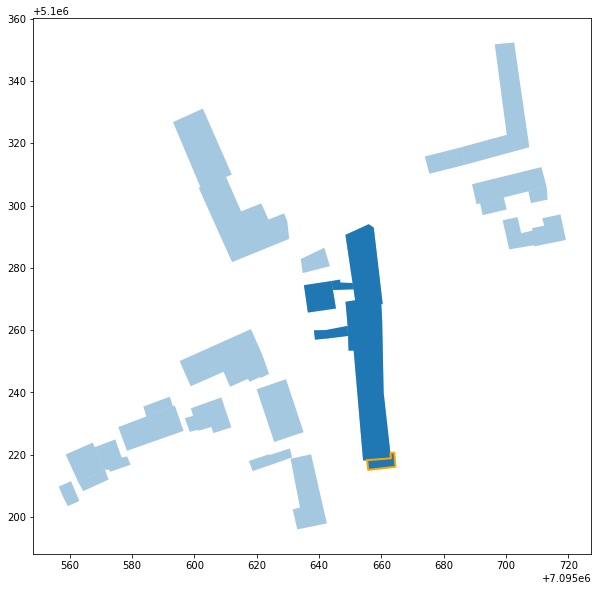

In [16]:
spatial_index = df.sindex

# Caclulate buffer around building i and find all buildings within buffer
buffer = df['geometry'].centroid[i].buffer(100)
possible_matches_index = list(spatial_index.intersection(buffer.bounds))
possible_matches = df.loc[possible_matches_index] 
precise_matches = possible_matches[possible_matches.intersects(buffer)]

# Store all buildings of TouchesIndexes in block dataframe
block = df.loc[df.loc[i]['TouchesIndexes']]

# Display Sample
fig, ax = plt.subplots(figsize=(10,10))
precise_matches.plot(ax=ax, alpha = 0.4)
block.plot(ax=ax)
plt.plot(*df.loc[i]['geometry'].exterior.xy, color='orange',linewidth=2)
plt.show() 

## 3.2 Further Analysis
### a) Analysis of overlapping segments

At first we look at the specific block in which our chosen building (marked with red line) touches other buildings

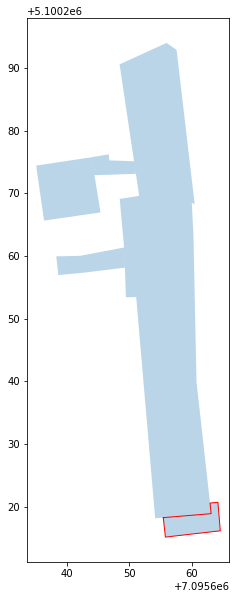

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
block.plot(ax=ax, alpha = 0.3)
plt.plot(*df.loc[i]['geometry'].exterior.xy, color='red',linewidth=1)

In a second step, lets calculate the number of touches and the sharedwalllength for the block

In [30]:
# Create empty result DataFrame
df_results = pd.DataFrame(index=df.index)

# for every building in df turn polygon in linearring of exterior of shape and save in gdf_exterior
gdf_exterior = gpd.GeoDataFrame(geometry=df.geometry.exterior)

# Spatial join between gdf_extterior and df by intersecting linestrings from gdf_exterior with polygons from df
# This will remove all rows from gdf_exterior that don't intersect polygons of df.
# This will generate a new line for each intersection df(index) and df(index_right),
# where we can have several df(index_right) for one df(index)
joined_gdf = gpd.sjoin(gdf_exterior, df, how="left", op='intersects')
# as gdf_exterior will intersect with df for the same building, this line removes those buildings.
# Afterwards, joined_gdf will only contain buildings that intersect with other buildings, so we can count them and calculate SharedWallLength.
joined_gdf = joined_gdf[joined_gdf.index != joined_gdf.index_right]

def get_inter_length(row):
    # returns length of intersection between building pairs in joined_gdf
    # by using geometry from df(index_right)
    return row.geometry.intersection(df.loc[row.index_right].geometry).length

# Compute adjacent shared perimeter and count
# for each touchin building pair 
# we compute the shared length as a new column by using get_inter_length function
joined_gdf['shared_length'] = joined_gdf.apply(get_inter_length, axis=1)
# Group by index from joined_gdf (aggregate all building pairs for one building) and sum up shared length and count
total_shared = joined_gdf.groupby(joined_gdf.index)['shared_length'].sum()
total_count = joined_gdf.groupby(joined_gdf.index)['shared_length'].count()

# Initialise final columns with 0
df_results['CountTouches'] = 0
df_results['SharedWallLength'] = 0
# add counts and shared length values to the  buildings that touch other buildings by matching the index
df_results.loc[total_count.index, 'CountTouches'] = total_count
df_results.loc[total_shared.index, 'SharedWallLength'] = total_shared

For building i, the CountTouches and SharedWalllength is as follows:

In [35]:
print(df_results.loc[i])

CountTouches        1.000000
SharedWallLength    9.364272
Name: 5, dtype: float64


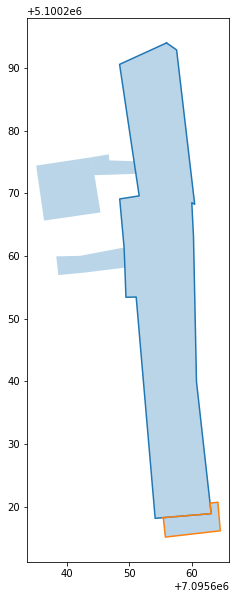

In [68]:
# This figure visualises the two touching buildings within the block 
fig, ax = plt.subplots(figsize=(10,10))
block.plot(ax=ax, alpha = 0.3)
plt.plot(*df.loc[joined_gdf.loc[i].index_right]['geometry'].exterior.xy)
plt.plot(*df.loc[i]['geometry'].exterior.xy)


### TODO: plot intersecting line to highlight shared_walllength
### Add edgecase, where building is within other building
### Add edgecase, where data is unclear